In [1]:
'''
    Evaluate normalized mutual information 
'''

%matplotlib inline 

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geojson

from shapely import geometry
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Polygon, mapping
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import shape, Point
from descartes import PolygonPatch
from ast import literal_eval

import seaborn as sns
import pytess
import fiona 

import rasterio
import shapefile as shp
from rasterio.plot import show
from rasterstats import zonal_stats
import geopandas as gpd

In [12]:
''' Evaluate normalized mutual information for SOM centroid stability heuristic '''

# centroids from multiple runs of SOM with same init params
data_1 = pd.read_csv('../data/centroids-9-11-som-40e-i.csv')
data_2 = pd.read_csv('../data/centroids-9-11-som-40e-ii.csv')

# social media points
df_weibo = pd.read_csv('../data/inLabelRegionPoints.csv')

# get beijing geojson data for plotting
with open("../data/beijing.geojson") as json_file:
    json_data = geojson.load(json_file)

In [3]:
# define functions for analysis

def getCoords(r): 
    return (Point(r[0]), Polygon(r[1]))

def getInPolyPoints(poly, df): 
    bounds = poly.bounds
    d = df.loc[(df['lat'] >= bounds[1]) & (df['lat'] <= bounds[3]) \
        & (df['lon'] >= bounds[0]) & (df['lon'] <= bounds[2])]
    d['labelInPoly'] = d.apply(lambda row: labelInPoly(row), axis=1)
    return d.loc[d['labelInPoly'] == 'in']

def labelInPoly(row): 
    point = Point(row['lon'], row['lat'])
    out = 'out'
    if poly.contains(point):
            out = 'in'
    return out

def makeJoinVal(row): 
    a = str(row['lat'])
    b = str(row['lon'])
    return a + '_' + b

def hasBoth(row):
    if row['lat_y'] > 0: 
        if row['lat_x'] > 0: 
            out = 1
        else: 
            out = 0
    else: 
        out = 0
    return out

In [4]:
# get corners of ROI from data to restrict plots
maxLon, minLon = np.max(df_weibo['lon']), np.min(df_weibo['lon'])
maxLat, minLat = np.max(df_weibo['lat']), np.min(df_weibo['lat'])
corners = [(minLon, maxLat), (maxLon, maxLat), (maxLon, minLat), (minLon, minLat)]
dfCorners = pd.DataFrame(corners)
dfCorners.columns = ['lon', 'lat']

In [5]:
# build polygons for first init of SOM given constant params
subset = data_1[['lon', 'lat']]
points = [tuple(x) for x in subset.values]
vPolys = pytess.voronoi(points)
polygons_with_centroids = [i for i in vPolys if i[0] != None]

polygons = [getCoords(i) for i in polygons_with_centroids]
dfPolygon = pd.DataFrame(polygons) 

dfPolygon.columns = ['center', 'polygon']
dfPolygon.reset_index(inplace=True)
dfPolygon.columns = ['polygonID', 'center', 'polygon']


schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int', 
                    'center_lon' : 'float', 
                    'center_lat' : 'float'},
}


shape_path = '../data/data_1/data_1.shp'
with fiona.open(shape_path, 'w', 'ESRI Shapefile', schema) as c:
   for i in range(len(dfPolygon)): 
        r = dfPolygon.iloc[i]
        c.write({
            'geometry': mapping(r['polygon']),
            'properties': { 'id': i,
                            'center_lon': r['center'].coords.xy[0][0], 
                            'center_lat': r['center'].coords.xy[1][0]},
        })

In [6]:
# build polygons for second init of SOM given constant params
subset = data_2[['lon', 'lat']]
points = [tuple(x) for x in subset.values]
vPolys = pytess.voronoi(points)
polygons_with_centroids = [i for i in vPolys if i[0] != None]

polygons = [getCoords(i) for i in polygons_with_centroids]
dfPolygon2 = pd.DataFrame(polygons) 

dfPolygon2.columns = ['center', 'polygon']
dfPolygon2.reset_index(inplace=True)
dfPolygon2.columns = ['polygonID', 'center', 'polygon']


schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int', 
                    'center_lon' : 'float', 
                    'center_lat' : 'float'},
}


shape_path = '../data/data_2/data_2.shp'
with fiona.open(shape_path, 'w', 'ESRI Shapefile', schema) as c:
   for i in range(len(dfPolygon2)): 
        r = dfPolygon2.iloc[i]
        c.write({
            'geometry': mapping(r['polygon']),
            'properties': { 'id': i,
                            'center_lon': r['center'].coords.xy[0][0], 
                            'center_lat': r['center'].coords.xy[1][0]},
        })

In [7]:
# load shapefile we just built for first SOM centroids
roi_path = "../data/data_1/data_1.shp"
ROI_shp=gpd.read_file(roi_path)
ROI_shp["Name"]= ['Feature_'+str(x) for x in range(0, len(ROI_shp))]
ROI=shp.Reader(roi_path)


# load shapefile we just built for second SOM centroids
roi_path = "../data/data_2/data_2.shp"
ROI2_shp=gpd.read_file(roi_path)
ROI2_shp["Name"]= ['Feature_'+str(x) for x in range(0, len(ROI2_shp))]
ROI2=shp.Reader(roi_path)

In [8]:
# intersect social media data with shapefiles from tesselation 
polygon_metrics = []
for i in range(0, len(ROI.shapeRecords())):
    shape = ROI.shapeRecords()[i]
    polygon = shape.shape.points[:]
    out = {
        'polygon' : polygon
    }
    polygon_metrics.append(out)

df_polygon = pd.DataFrame(polygon_metrics)
df_polygon.reset_index(inplace=True)
df_polygon.columns = [u'polygon_id', u'polygon']

polygon_metrics2 = []
for i in range(0, len(ROI2.shapeRecords())):
    shape = ROI2.shapeRecords()[i]
    polygon = shape.shape.points[:]
    out = {
        'polygon' : polygon
    }
    polygon_metrics2.append(out)

df_polygon2 = pd.DataFrame(polygon_metrics2)
df_polygon2.reset_index(inplace=True)
df_polygon2.columns = [u'polygon_id', u'polygon']

dfTemp = df_weibo
inpolys = []
for p in range(len(df_polygon)):
    try: 
        polyRow = df_polygon.iloc[p]
        poly = polyRow['polygon']
        label = polyRow['polygon_id']
        poly = geometry.Polygon(poly)
        polypoints = getInPolyPoints(poly, dfTemp)
        polypoints['polygon_id'] = polypoints.apply(lambda row: label, axis=1)
        polypoints['polygon'] = polypoints.apply(lambda row: poly, axis=1)
        dfTemp = dfTemp.iloc[~dfTemp.index.isin(polypoints.index.tolist())]
        inpolys.append(polypoints)
    except: 
        print('error on polygon_id ' + str(p))

df_weibo_poly = pd.concat(inpolys)

dfTemp = df_weibo
inpolys2 = []
for p in range(len(df_polygon2)):
    try: 
        polyRow = df_polygon2.iloc[p]
        poly = polyRow['polygon']
        label = polyRow['polygon_id']
        poly = geometry.Polygon(poly)
        polypoints = getInPolyPoints(poly, dfTemp)
        polypoints['polygon_id'] = polypoints.apply(lambda row: label, axis=1)
        polypoints['polygon'] = polypoints.apply(lambda row: poly, axis=1)
        dfTemp = dfTemp.iloc[~dfTemp.index.isin(polypoints.index.tolist())]
        inpolys2.append(polypoints)
    except: 
        print('error on polygon_id ' + str(p))

df_weibo_poly2 = pd.concat(inpolys2)

/Users/culhane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
# create join key and join frames together (there is some cardinality issues that need to be resolved)
data1_frame = df_weibo_poly[['polygon_id', 'lat', 'lon']]
data1 = data1_frame.drop_duplicates() 
data2_frame = df_weibo_poly2[['polygon_id', 'lat', 'lon']]
data2 = data2_frame.drop_duplicates() 
data1['joinVal'] = data1.apply(lambda row: makeJoinVal(row), axis=1)
data2['joinVal'] = data2.apply(lambda row: makeJoinVal(row), axis=1)
joined = pd.merge(data1, data2, on='joinVal', how='outer')

/Users/culhane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/culhane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
# ignore cardinality issue for now and just consider records where the join is complete
joined['is_valid'] = joined.apply(lambda row: hasBoth(row), axis =1 )
join = joined.loc[joined['is_valid'] == 1 ]

In [11]:
# view data 
join.head() 

,polygon_id_x,lat_x,lon_x,joinVal,polygon_id_y,lat_y,lon_y,is_valid
0,0,40.174683,116.163103,40.174683200000004_116.16310290000001,98,40.174683,116.163103,1
1,0,40.137140,116.139810,40.13714_116.13981000000001,98,40.137140,116.139810,1
2,0,40.125320,116.157317,40.12532029_116.15731652,86,40.125320,116.157317,1
3,0,40.125457,116.157778,40.12545672_116.15777761,86,40.125457,116.157778,1
4,0,40.180586,116.159735,40.180586_116.15973500000001,98,40.180586,116.159735,1


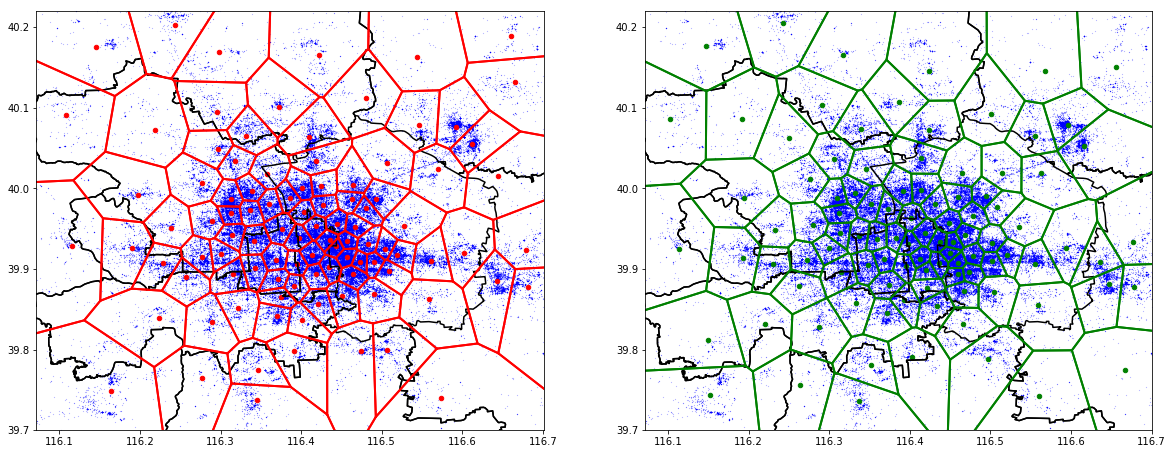

In [18]:
# plot geojson region to show corners 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax1.plot(x, y, color='black')
        ax1.axis('scaled')
        ax2.plot(x, y, color='black')
        ax2.axis('scaled')
    except: 
        continue

# plot tesselation for first SOM init
for shape in ROI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x,y, color='red', linewidth=2)
    
# plot tesselation for second SOM init
for shape in ROI2.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x,y, color='green', linewidth=2)

# plot scatter of social media points over both sets of polygons
ax1.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.01)
ax2.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.01)

# plot centroids from SOM clustering
ax1.scatter(data_1['lon'], data_1['lat'], color='red', s=20)
ax2.scatter(data_2['lon'], data_2['lat'], color='green', s=20)

# limit axes to ROI 
ax1.set_xlim(minLon, maxLon)
ax1.set_ylim(minLat, maxLat)
ax2.set_xlim(minLon, maxLon)
ax2.set_ylim(minLat, maxLat)

# reveal plot
plt.show()

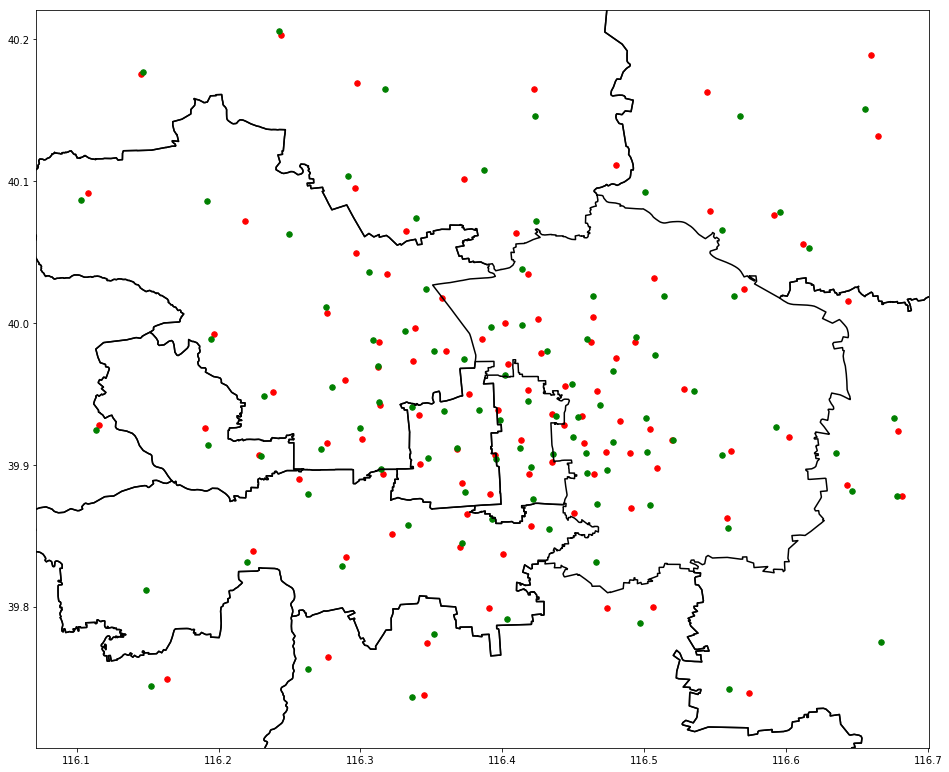

In [20]:
# plot geojson region to show corners 
fig = plt.figure(figsize=(16,16))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax = fig.gca() 
        ax.plot(x, y, color='black')
        ax.axis('scaled')
    except: 
        continue

# plot scatter of social media points over both sets of polygons
# ax.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.01)

# plot centroids from SOM clustering
ax.scatter(data_1['lon'], data_1['lat'], color='red', s=30)
ax.scatter(data_2['lon'], data_2['lat'], color='green', s=30)

# limit axes to ROI 
ax.set_xlim(minLon, maxLon)
ax.set_ylim(minLat, maxLat)

# reveal plot
plt.show()

In [21]:
# evaluate normalized mutual information
out = normalized_mutual_info_score(join.polygon_id_x.values.tolist(), join.polygon_id_y.values.tolist())

out

0.8506704841615789